<a href="https://colab.research.google.com/github/svandergoote/LGBIO2060-2022/blob/main/LGBIO2060_TP1_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LGBIO2060 Exercice session 1
__Authors:__ Simon Vandergooten and Clémence Vandamme

__Content inspired from__: Neuromatch Academy github.com/NeuromatchAcademy

In this first exercise session, you will first review the basics of statistics needed for the upcoming exercise sessions and projects. In a second part, you will use the bayesian inference to produce an estimate of a hidden binary state and take decisions based on this estimate and the associated uncertainty.

After this session you should be able to:
* Sample data from a specific probability distribution.
* Use basic probability rules to infer parameters.
* Understand and use the maximum likelihood principle.
* Understand the Bayes' rule and the impact of a prior in the inference.
* Use probability distribution to represent hidden states
* Combine new information with your prior knowledge
* Combine the possible loss (or gain) for making a decision with your probabilistic knowledge

## Imports and helper functions
**Please execute the cell(s) below to initialize the notebook environment.**

In [ ]:
#Import the libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import norm
from numpy.random import default_rng
from matplotlib import patches, transforms, gridspec
from scipy.optimize import fsolve
from collections import namedtuple
from scipy import stats
from scipy.special import erf

In [ ]:
#@title Figure Settings
import ipywidgets as widgets  # interactive display
from ipywidgets import interact, fixed, HBox, Layout, VBox, interactive, Label, interact_manual
from ipywidgets import GridspecLayout, HBox, VBox, FloatSlider, Layout, ToggleButtons
from ipywidgets import interactive, interactive_output, Checkbox, Select
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")
my_layout = widgets.Layout()

In [ ]:
#@title Plotting Functions

def plot_random_sample(x, y, figtitle = None):
    """ Plot the random sample between 0 and 1 for both the x and y axes.

    Args:
        x (ndarray): array of x coordinate values across the random sample
        y (ndarray): array of y coordinate values across the random sample
        figtitle (str): title of histogram plot (default is no title)

    Returns:
        Nothing.
    """
    fig, ax = plt.subplots()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.xlim([-0.25, 1.25]) # set x and y axis range to be a bit less than 0 and greater than 1
    plt.ylim([-0.25, 1.25])
    plt.scatter(dataX, dataY)
    if figtitle is not None:
        fig.suptitle(figtitle, size=16)
    plt.show()

def plot_random_walk(x, y, figtitle = None):
    """ Plots the random walk within the range 0 to 1 for both the x and y axes.

    Args:
        x (ndarray): array of steps in x direction
        y (ndarray): array of steps in y direction
        figtitle (str): title of histogram plot (default is no title)

    Returns:
        Nothing.
    """
    fig, ax = plt.subplots()
    plt.plot(x,y,'b-o', alpha = 0.5)
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    ax.set_xlabel('x location')
    ax.set_ylabel('y location')
    plt.plot(x[0], y[0], 'go')
    plt.plot(x[-1], y[-1], 'ro')

    if figtitle is not None:
        fig.suptitle(figtitle, size=16)
    plt.show()

def plot_hist(data, xlabel, figtitle = None, num_bins = None):
    """ Plot the given data as a histogram.

    Args:
        data (ndarray): array with data to plot as histogram
        xlabel (str): label of x-axis
        figtitle (str): title of histogram plot (default is no title)
        num_bins (int): number of bins for histogram (default is 10)

    Returns:
        count (ndarray): number of samples in each histogram bin
        bins (ndarray): center of each histogram bin
    """
    fig, ax = plt.subplots()
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count')
    if num_bins is not None:
        count, bins, _ = plt.hist(data, bins = num_bins)
    else:
        count, bins, _ = plt.hist(data, bins = np.arange(np.min(data)-.5, np.max(data)+.6)) # 10 bins default
    if figtitle is not None:
        fig.suptitle(figtitle, size=16)
    plt.show()
    return count, bins

def my_plot_single(x, px):
    """
    Plots normalized Gaussian distribution

    Args:
        x (numpy array of floats):     points at which the likelihood has been evaluated
        px (numpy array of floats):    normalized probabilities for prior evaluated at each `x`

    Returns:
        Nothing.
  """
    if px is None:
        px = np.zeros_like(x)

    fig, ax = plt.subplots()
    ax.plot(x, px, '-', color='C2', linewidth=2, label='Prior')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Orientation (Degrees)')

def plot_gaussian_samples_true(samples, xspace, mu, sigma, xlabel, ylabel):
    """ Plot a histogram of the data samples on the same plot as the gaussian
    distribution specified by the give mu and sigma values.

    Args:
        samples (ndarray): data samples for gaussian distribution
        xspace (ndarray): x values to sample from normal distribution
        mu (scalar): mean parameter of normal distribution
        sigma (scalar): variance parameter of normal distribution
        xlabel (str): the label of the x-axis of the histogram
        ylabel (str): the label of the y-axis of the histogram

    Returns:
        Nothing.
    """
    fig, ax = plt.subplots()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # num_samples = samples.shape[0]

    count, bins, _ = plt.hist(samples, density=True)
    plt.plot(xspace, norm.pdf(xspace, mu, sigma),'r-')
    plt.show()

def plot_likelihoods(likelihoods, mean_vals, variance_vals):
    """ Plot the likelihood values on a heatmap plot where the x and y axes match
    the mean and variance parameter values the likelihoods were computed for.

    Args:
        likelihoods (ndarray): array of computed likelihood values
        mean_vals (ndarray): array of mean parameter values for which the
                            likelihood was computed
        variance_vals (ndarray): array of variance parameter values for which the
                            likelihood was computed

    Returns:
        Nothing.
    """
    fig, ax = plt.subplots()
    im = ax.imshow(likelihoods)

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('log likelihood', rotation=-90, va="bottom")

    ax.set_xticks(np.arange(len(mean_vals)))
    ax.set_yticks(np.arange(len(variance_vals)))
    ax.set_xticklabels(mean_vals)
    ax.set_yticklabels(variance_vals)
    ax.set_xlabel('Mean')
    ax.set_ylabel('Variance')

def posterior_plot(x, likelihood=None, prior=None, posterior_pointwise=None, ax=None):
    """
    Plots normalized Gaussian distributions and posterior.

    Args:
        x (numpy array of floats):         points at which the likelihood has been evaluated
        auditory (numpy array of floats):  normalized probabilities for auditory likelihood evaluated at each `x`
        visual (numpy array of floats):    normalized probabilities for visual likelihood evaluated at each `x`
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
        ax: Axis in which to plot. If None, create new axis.

    Returns:
        Nothing.
    """
    if likelihood is None:
        likelihood = np.zeros_like(x)

    if prior is None:
        prior = np.zeros_like(x)

    if posterior_pointwise is None:
        posterior_pointwise = np.zeros_like(x)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(x, likelihood, '-C1', LineWidth=2, label='Auditory')
    ax.plot(x, prior, '-C0', LineWidth=2, label='Visual')
    ax.plot(x, posterior_pointwise, '-C2', LineWidth=2, label='Posterior')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Orientation (Degrees)')
    plt.show()

    return ax

def plot_classical_vs_bayesian_normal(num_points, mu_classic, var_classic,
                                      mu_bayes, var_bayes):
    """ Helper function to plot optimal normal distribution parameters for varying
    observed sample sizes using both classic and Bayesian inference methods.

    Args:
        num_points (int): max observed sample size to perform inference with
        mu_classic (ndarray): estimated mean parameter for each observed sample size
                                using classic inference method
        var_classic (ndarray): estimated variance parameter for each observed sample size
                                using classic inference method
        mu_bayes (ndarray): estimated mean parameter for each observed sample size
                                using Bayesian inference method
        var_bayes (ndarray): estimated variance parameter for each observed sample size
                                using Bayesian inference method

    Returns:
        Nothing.
    """
    xspace = np.linspace(0, num_points, num_points)
    fig, ax = plt.subplots()
    ax.set_xlabel('n data points')
    ax.set_ylabel('mu')
    plt.plot(xspace, mu_classic,'r-', label = "Classical")
    plt.plot(xspace, mu_bayes,'b-', label = "Bayes")
    plt.legend()
    plt.show()

    fig, ax = plt.subplots()
    ax.set_xlabel('n data points')
    ax.set_ylabel('sigma^2')
    plt.plot(xspace, var_classic,'r-', label = "Classical")
    plt.plot(xspace, var_bayes,'b-', label = "Bayes")
    plt.legend()
    plt.show()

# @title Plotting Functions

def plot_prior_likelihood_posterior(prior, likelihood, posterior):

    # definitions for the axes
    left, width = 0.05, 0.3
    bottom, height = 0.05, 0.9
    padding = 0.12
    small_width = 0.1
    left_space = left + small_width + padding
    added_space = padding + width

    fig = plt.figure(figsize=(12, 4))

    rect_prior = [left, bottom, small_width, height]
    rect_likelihood = [left_space , bottom , width, height]
    rect_posterior = [left_space +  added_space, bottom , width, height]

    ax_prior = fig.add_axes(rect_prior)
    ax_likelihood = fig.add_axes(rect_likelihood, sharey=ax_prior)
    ax_posterior = fig.add_axes(rect_posterior, sharey = ax_prior)

    rect_colormap = plt.cm.Blues

    # Show posterior probs and marginals
    ax_prior.barh(0, prior[0], facecolor = rect_colormap(prior[0, 0]))
    ax_prior.barh(1, prior[1], facecolor = rect_colormap(prior[1, 0]))
    ax_likelihood.matshow(likelihood, vmin=0., vmax=1., cmap='Reds')
    ax_posterior.matshow(posterior, vmin=0., vmax=1., cmap='Greens')


    # Probabilities plot details
    # ax_prior.set(xlim = [1, 0], yticks = [0, 1], yticklabels = ['left', 'right'],
    #              ylabel = 'state (s)', title = "Prior p(s)")
    ax_prior.set(xlim = [1, 0], xticks = [], yticks = [0, 1], yticklabels = ['left', 'right'],
                 title = "Prior p(s)")
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Likelihood plot details
    ax_likelihood.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'],
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)',
                   title = 'Likelihood p(m (left) | s)')
    ax_likelihood.xaxis.set_ticks_position('bottom')
    ax_likelihood.spines['left'].set_visible(False)
    ax_likelihood.spines['bottom'].set_visible(False)

    # Posterior plot details

    ax_posterior.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'],
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)',
                   title = 'Posterior p(s | m)')
    ax_posterior.xaxis.set_ticks_position('bottom')
    ax_posterior.spines['left'].set_visible(False)
    ax_posterior.spines['bottom'].set_visible(False)


    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{posterior[i,j]:.2f}"
        ax_posterior.text(j,i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{likelihood[i,j]:.2f}"
        ax_likelihood.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i, 0]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')


def plot_prior_likelihood(ps, p_a_s1, p_a_s0, measurement):
    likelihood = np.asarray([[p_a_s1, 1-p_a_s1],[p_a_s0, 1-p_a_s0]])
    assert 0.0 <= ps <= 1.0
    prior = np.asarray([ps, 1 - ps])
    if measurement == "Fish":
        posterior = likelihood[:, 0] * prior
    else:
        posterior = (likelihood[:, 1] * prior).reshape(-1)
    posterior /= np.sum(posterior)

    # definitions for the axes
    left, width = 0.05, 0.3
    bottom, height = 0.05, 0.9
    padding = 0.12
    small_width = 0.2
    left_space = left + small_width + padding
    small_padding = 0.05

    fig = plt.figure(figsize=(12, 4))

    rect_prior = [left, bottom, small_width, height]
    rect_likelihood = [left_space , bottom , width, height]
    rect_posterior = [left_space + width + small_padding, bottom , small_width, height]

    ax_prior = fig.add_axes(rect_prior)
    ax_likelihood = fig.add_axes(rect_likelihood, sharey=ax_prior)
    ax_posterior = fig.add_axes(rect_posterior, sharey=ax_prior)

    prior_colormap = plt.cm.Blues
    posterior_colormap = plt.cm.Greens

    # Show posterior probs and marginals
    ax_prior.barh(0, prior[0], facecolor = prior_colormap(prior[0]))
    ax_prior.barh(1, prior[1], facecolor = prior_colormap(prior[1]))
    ax_likelihood.matshow(likelihood, vmin=0., vmax=1., cmap='Reds')
    # ax_posterior.matshow(posterior, vmin=0., vmax=1., cmap='')
    ax_posterior.barh(0, posterior[0], facecolor = posterior_colormap(posterior[0]))
    ax_posterior.barh(1, posterior[1], facecolor = posterior_colormap(posterior[1]))

    # Probabilities plot details
    ax_prior.set(xlim = [1, 0], yticks = [0, 1], yticklabels = ['left', 'right'],
                 title = "Prior p(s)", xticks = [])
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Likelihood plot details
    ax_likelihood.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'],
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)',
                   title = 'Likelihood p(m | s)')
    ax_likelihood.xaxis.set_ticks_position('bottom')
    ax_likelihood.spines['left'].set_visible(False)
    ax_likelihood.spines['bottom'].set_visible(False)

    # Posterior plot details
    ax_posterior.set(xlim = [0, 1], xticks = [], yticks = [0, 1],
                     yticklabels = ['left', 'right'], title = "Posterior p(s | m)")
    ax_posterior.spines['left'].set_visible(False)
    ax_posterior.spines['bottom'].set_visible(False)

    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    # for i,j in zip(x.flatten(), y.flatten()):
    #     c = f"{posterior[i,j]:.2f}"
    #     ax_posterior.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = posterior[i]
        c = f"{v:.2f}"
        ax_posterior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{likelihood[i,j]:.2f}"
        ax_likelihood.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')
    plt.show()


from matplotlib import colors
def plot_utility(ps):
    prior = np.asarray([ps, 1 - ps])

    utility = np.array([[2, -3], [-2, 1]])

    expected = prior @ utility

    # definitions for the axes
    left, width = 0.05, 0.16
    bottom, height = 0.05, 0.9
    padding = 0.02
    small_width = 0.1
    left_space = left + small_width + padding
    added_space = padding + width

    fig = plt.figure(figsize=(17, 3))

    rect_prior = [left, bottom, small_width, height]
    rect_utility = [left + added_space , bottom , width, height]
    rect_expected = [left + 2* added_space, bottom , width, height]

    ax_prior = fig.add_axes(rect_prior)
    ax_utility = fig.add_axes(rect_utility, sharey=ax_prior)
    ax_expected = fig.add_axes(rect_expected)

    rect_colormap = plt.cm.Blues

    # Data of plots
    ax_prior.barh(0, prior[0], facecolor = rect_colormap(prior[0]))
    ax_prior.barh(1, prior[1], facecolor = rect_colormap(prior[1]))
    ax_utility.matshow(utility, cmap='cool')
    norm = colors.Normalize(vmin=-3, vmax=3)
    ax_expected.bar(0, expected[0], facecolor = rect_colormap(norm(expected[0])))
    ax_expected.bar(1, expected[1], facecolor = rect_colormap(norm(expected[1])))

    # Probabilities plot details
    ax_prior.set(xlim = [1, 0], xticks = [], yticks = [0, 1], yticklabels = ['left', 'right'],
                 title = "Probability of state")
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Utility plot details
    ax_utility.set(xticks = [0, 1], xticklabels = ['left', 'right'],
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'action (a)',
                   title = 'Utility')
    ax_utility.xaxis.set_ticks_position('bottom')
    ax_utility.spines['left'].set_visible(False)
    ax_utility.spines['bottom'].set_visible(False)

    # Expected utility plot details
    ax_expected.set(title = 'Expected utility', ylim = [-3, 3],
                    xticks = [0, 1], xticklabels = ['left', 'right'],
                    xlabel = 'action (a)',
                    yticks = [])
    ax_expected.xaxis.set_ticks_position('bottom')
    ax_expected.spines['left'].set_visible(False)
    ax_expected.spines['bottom'].set_visible(False)

    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)

    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{utility[i,j]:.2f}"
        ax_utility.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i in ind:
        v = expected[i]
        c = f"{v:.2f}"
        ax_expected.text(i, 2.5, c, va='center', ha='center', color='black')

    return fig


def plot_prior_likelihood_utility(ps, p_a_s1, p_a_s0, measurement):
    assert 0.0 <= ps <= 1.0
    assert 0.0 <= p_a_s1 <= 1.0
    assert 0.0 <= p_a_s0 <= 1.0
    prior = np.asarray([ps, 1 - ps])
    likelihood = np.asarray([[p_a_s1, 1-p_a_s1],[p_a_s0, 1-p_a_s0]])
    utility = np.array([[2.0, -3.0], [-2.0, 1.0]])
    # expected = np.zeros_like(utility)

    if measurement == "Fish":
        posterior = likelihood[:, 0] * prior
    else:
        posterior = (likelihood[:, 1] * prior).reshape(-1)
    posterior /= np.sum(posterior)
    # expected[:, 0] = utility[:, 0] * posterior
    # expected[:, 1] = utility[:, 1] * posterior
    expected = posterior @ utility

    # definitions for the axes
    left, width = 0.05, 0.3
    bottom, height = 0.05, 0.3
    padding = 0.12
    small_width = 0.2
    left_space = left + small_width + padding
    small_padding = 0.05

    fig = plt.figure(figsize=(10, 9))

    rect_prior = [left, bottom + height + padding, small_width, height]
    rect_likelihood = [left_space , bottom + height + padding , width, height]
    rect_posterior = [left_space + width + small_padding, bottom + height + padding , small_width, height]

    rect_utility = [padding, bottom, width, height]
    rect_expected = [padding + width + padding + left, bottom, width, height]

    ax_likelihood = fig.add_axes(rect_likelihood)
    ax_prior = fig.add_axes(rect_prior, sharey=ax_likelihood)
    ax_posterior = fig.add_axes(rect_posterior, sharey=ax_likelihood)
    ax_utility = fig.add_axes(rect_utility)
    ax_expected = fig.add_axes(rect_expected)

    prior_colormap = plt.cm.Blues
    posterior_colormap = plt.cm.Greens
    expected_colormap = plt.cm.Wistia

    # Show posterior probs and marginals
    ax_prior.barh(0, prior[0], facecolor = prior_colormap(prior[0]))
    ax_prior.barh(1, prior[1], facecolor = prior_colormap(prior[1]))
    ax_likelihood.matshow(likelihood, vmin=0., vmax=1., cmap='Reds')
    ax_posterior.barh(0, posterior[0], facecolor = posterior_colormap(posterior[0]))
    ax_posterior.barh(1, posterior[1], facecolor = posterior_colormap(posterior[1]))
    ax_utility.matshow(utility, vmin=0., vmax=1., cmap='cool')
    # ax_expected.matshow(expected, vmin=0., vmax=1., cmap='Wistia')
    ax_expected.bar(0, expected[0], facecolor = expected_colormap(expected[0]))
    ax_expected.bar(1, expected[1], facecolor = expected_colormap(expected[1]))

    # Probabilities plot details
    ax_prior.set(xlim = [1, 0], yticks = [0, 1], yticklabels = ['left', 'right'],
                 title = "Prior p(s)", xticks = [])
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Likelihood plot details
    ax_likelihood.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'],
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)',
                   title = 'Likelihood p(m | s)')
    ax_likelihood.xaxis.set_ticks_position('bottom')
    ax_likelihood.spines['left'].set_visible(False)
    ax_likelihood.spines['bottom'].set_visible(False)

    # Posterior plot details
    ax_posterior.set(xlim = [0, 1], xticks = [], yticks = [0, 1],
                     yticklabels = ['left', 'right'], title = "Posterior p(s | m)")
    ax_posterior.spines['left'].set_visible(False)
    ax_posterior.spines['bottom'].set_visible(False)

    # Utility plot details
    ax_utility.set(xticks = [0, 1], xticklabels = ['left', 'right'],
                   xlabel = 'action (a)', yticks = [0, 1], yticklabels = ['left', 'right'],
                   title = 'Utility', ylabel = 'state (s)')
    ax_utility.xaxis.set_ticks_position('bottom')
    ax_utility.spines['left'].set_visible(False)
    ax_utility.spines['bottom'].set_visible(False)

    # Expected Utility plot details
    ax_expected.set(ylim = [-2, 2], xticks = [0, 1], xticklabels = ['left', 'right'],
                 xlabel = 'action (a)', title = 'Expected utility', yticks=[])
    # ax_expected.axis('off')
    ax_expected.spines['left'].set_visible(False)
    # ax_expected.set(xticks = [0, 1], xticklabels = ['left', 'right'],
    #                 xlabel = 'action (a)',
    #                title = 'Expected utility')
    # ax_expected.xaxis.set_ticks_position('bottom')
    # ax_expected.spines['left'].set_visible(False)
    # ax_expected.spines['bottom'].set_visible(False)

    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    for i in ind:
        v = posterior[i]
        c = f"{v:.2f}"
        ax_posterior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{likelihood[i,j]:.2f}"
        ax_likelihood.text(j,i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{utility[i,j]:.2f}"
        ax_utility.text(j,i, c, va='center', ha='center', color='black')
    # for i,j in zip(x.flatten(), y.flatten()):
    #     c = f"{expected[i,j]:.2f}"
    #     ax_expected.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i in ind:
        v = expected[i]
        c = f"{v:.2f}"
        ax_expected.text(i, v, c, va='center', ha='center', color='black')

    plt.show()

## Section 1: Probability distribution

This section will be devoted to the exploration of some probability distribution and discover some useful functions.

### 1.1: Create randomness

Numpy has many functions and capabilities related to randomness.  We can draw random numbers from various probability distributions. For example, to draw 5 uniform numbers between 0 and 100, you would use `np.random.uniform(0, 100, size = (5,))`.

 We will use `np.random.seed` to set a specific seed for the random number generator. For example, `np.random.seed(0)` sets the seed as 0. By including this, we are actually making the random numbers reproducible, which may seem odd at first. Basically if we do the below code without that 0, we would get different random numbers every time we run it. By setting the seed to 0, we ensure we will get the same random numbers. There are lots of reasons we may want randomness to be reproducible.

```
np.random.seed(0)
random_nums = np.random.uniform(0, 100, size = (5,))
```

Below, you will complete a function `generate_random_sample` that randomly generates `num_points` $x$ and $y$ coordinate values drawn from a uniform distribution, all within the range 0 to 1. You will then generate 10 points and visualize.

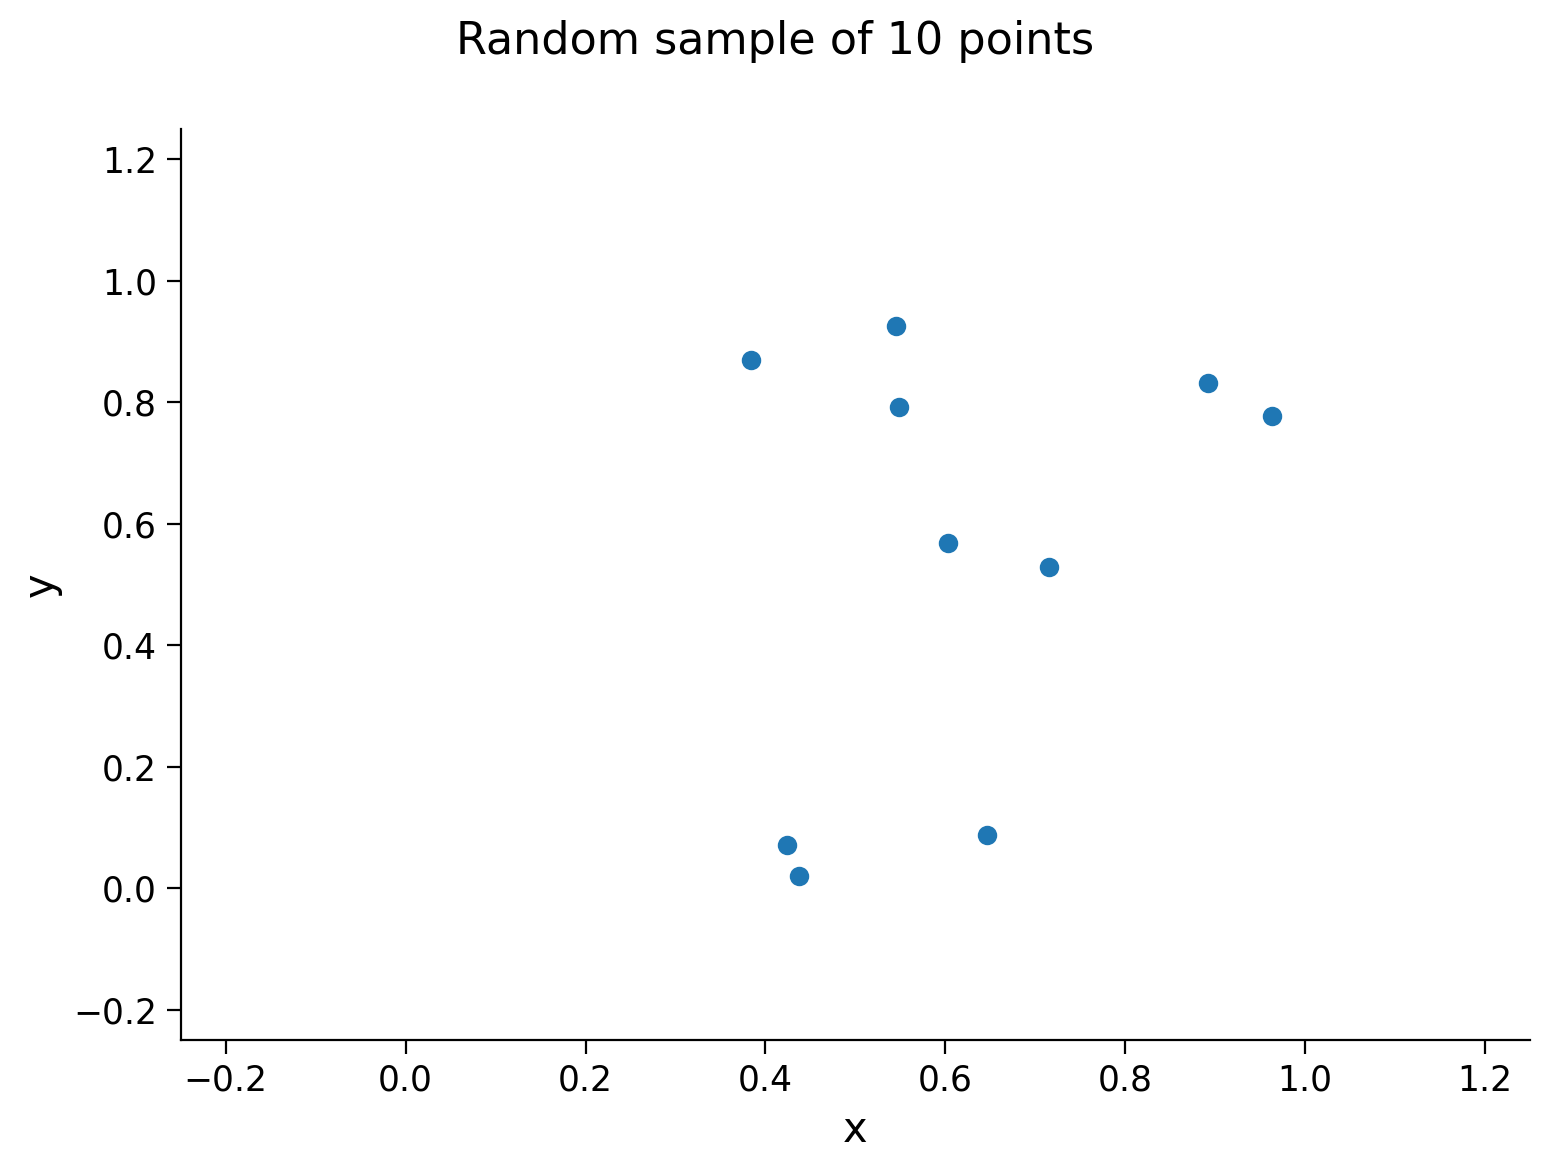

In [ ]:
def generate_random_sample(num_points):
    """ Generate a random sample containing a desired number of points (num_points)
    in the range [0, 1] using a random number generator object.

     Args:
       num_points (int): number of points desired in random sample

     Returns:
       dataX, dataY (ndarray, ndarray): arrays of size (num_points,) containing x
       and y coordinates of sampled points

     """
    ###################################################################
    ## TODO for students: Draw the uniform numbers
    ###################################################################
    dataX = np.random.uniform(0, 1, num_points)
    dataY = np.random.uniform(0, 1, num_points)

    return dataX, dataY
    ###################################################################

# Set a seed
np.random.seed(0)

# Set number of points to draw
num_points = 10

# Draw random points
dataX, dataY = generate_random_sample(num_points)

# Visualize
plot_random_sample(dataX, dataY, "Random sample of 10 points")

### 1.2: Gaussian Distribution

The most widely used continuous distribution is probably the Gaussian distribution. It is extremely common across all kinds of statistical analyses. Because of the central limit theorem, many quantities are Gaussian distributed. Gaussians also have some nice mathematical properties that permit simple closed-form solutions to several important problems.

As a working example, imagine that a human participant is asked to point in the direction where they perceived a sound coming from. As an approximation, we can assume that the direction they point towards is Gaussian distributed, with a mean on target and variance depending on the error range.

In this exercise, you will implement a Gaussian by filling in the missing portions of code for the function `my_gaussian` below. Gaussians have two parameters. The **mean** $\mu$, which sets the location of its center, and its "scale" or spread is controlled by its **standard deviation** $\sigma$, or **variance** $\sigma^2$ (i.e. the square of standard deviation). **Be careful not to use one when the other is required.**

The equation for a Gaussian probability density function is:
$$
f(x;\mu,\sigma^2)=\mathcal{N}(\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)
$$
In Python $\pi$ and $e$ can be written as `np.pi` and `np.exp` respectively.

As a probability distribution this has an integral of one when integrated from $-\infty$ to $\infty$. However, in the following, your numerical Gaussian will only be computed over a finite number of points. You therefore need to explicitly normalize it to sum to one yourself based on the `step_size` used.

You can test your function with $\mu= 1$ and $\sigma = 1.5$

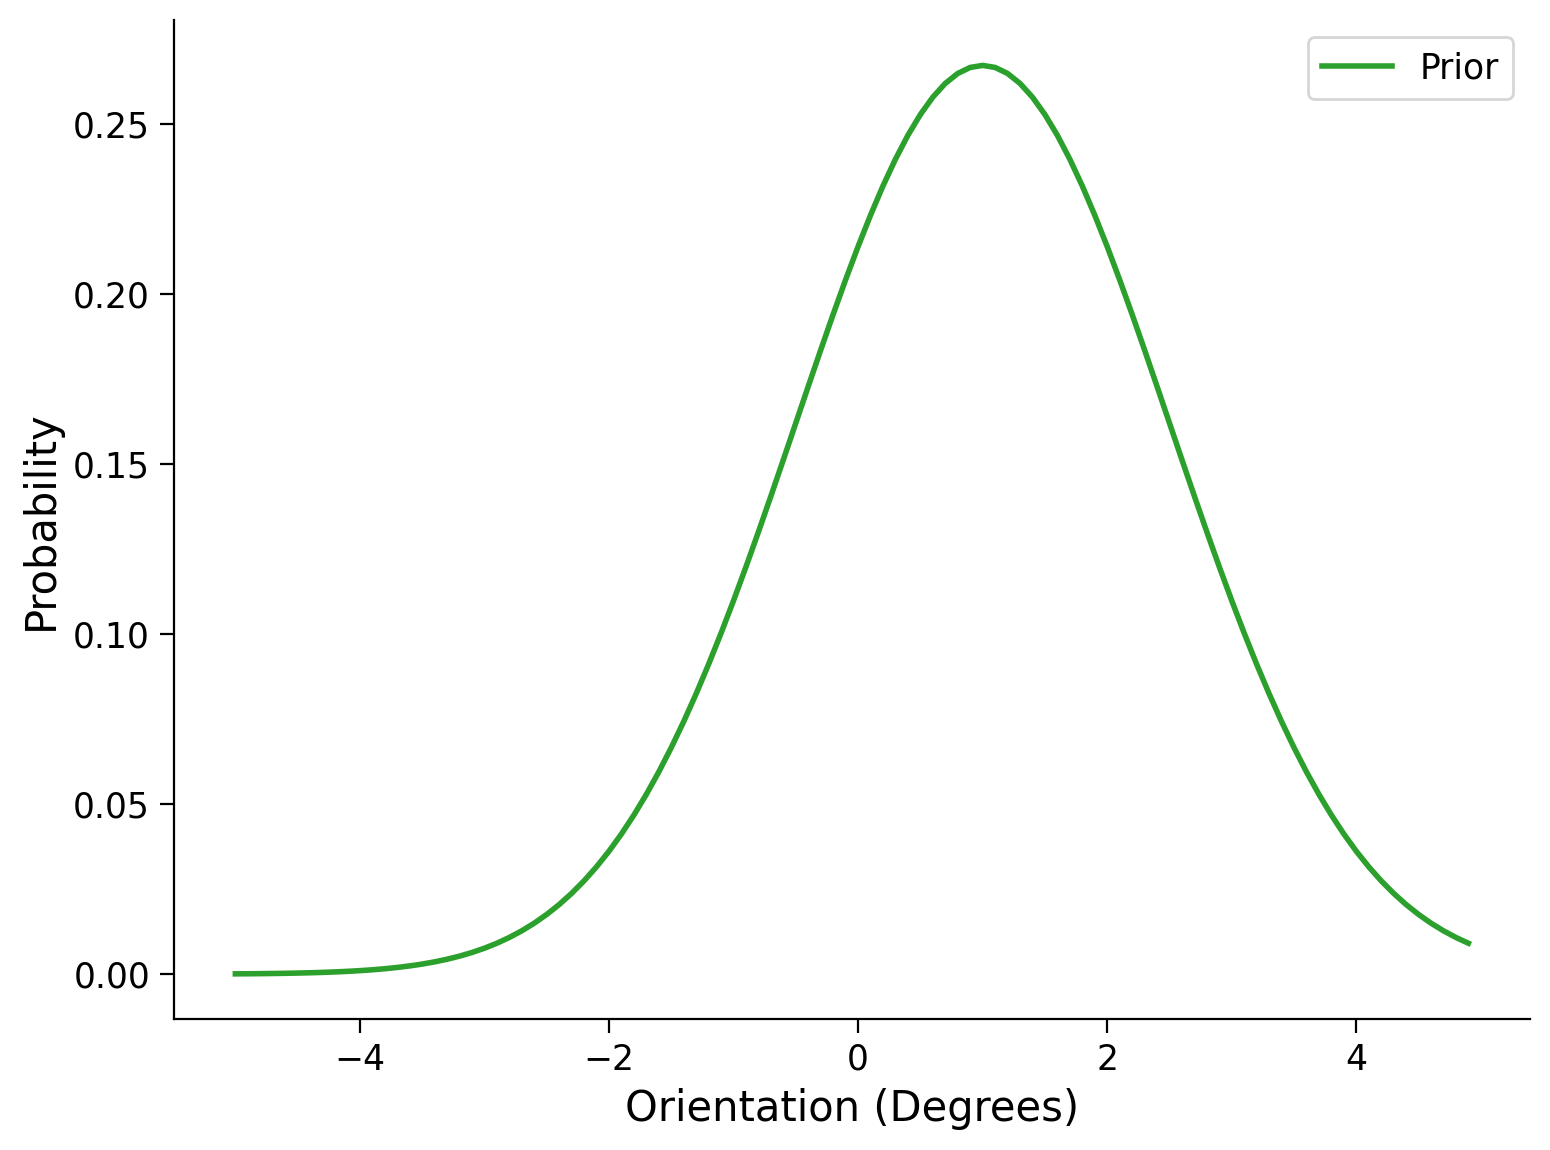

In [ ]:
def my_gaussian(x_points, mu, sigma):
    """ Returns normalized Gaussian estimated at points `x_points`, with
    parameters: mean `mu` and standard deviation `sigma`

    Args:
      x_points (ndarray of floats): points at which the gaussian is evaluated
      mu (scalar): mean of the Gaussian
      sigma (scalar): standard deviation of the gaussian

    Returns:
      (numpy array of floats) : normalized Gaussian evaluated at `x`
    """
    ###################################################################
    ## TODO for students: Implement the gaussian equation
    ###################################################################
    dx = x_points[1] - x_points[0]
    px = np.exp(-(x_points - mu)**2/(2 * sigma**2))/np.sqrt(2 * np.pi * sigma**2)
    #Do not forget to normalize
    return px/(dx
               *sum(px))

#Choose some parameters
mu = 1
sigma = 1.5

###################################################################
#Create data
step_size = 0.1
x_points = np.arange(-5, 5, step_size)

#Generate the Gaussian
Gaussian = my_gaussian(x_points, mu, sigma)


#Visualise
my_plot_single(x_points, Gaussian)

*Example output:*


<img alt='Solution hint' align='left' width=413 height=300 src=https://raw.githubusercontent.com/svandergoote/LGBIO2060-2021/master/Solutions/TP1_ex1.PNG>

## Section 2: Statistical inference
The goal of this section is to explain how it is possible to do inference by inverting the generative process.

By completing the exercises in this tutorial, you should:
* understand what the likelihood function is, and have some intuition of why it is important
* know how to summarise the Gaussian distribution using mean and variance
* know how to maximise a likelihood function
* be able to do simple inference in both classical and Bayesian ways

### 2.1 Likelihoods
Most of the times when you are trying to model something you have two things:

* Observations/data **x**.
* A probabilistic model $P(x|\theta)$

And your goal is to estimate the hidden properties $\theta$ that gave rise to the data **x**.

For example, if your probabilistic model is a Gaussian distribution $\mathcal{N}(x_i,\mu,\sigma)$ your goal is to find the parameters $\theta=\{\mu,\sigma\}$ that maximise the probability that your data **x** were obtained given those parameters.

A classical method to achieve such result is the **maximum likelihood**, which consists to maximise the probability of model with regard to $\theta$.

$$\hat\theta = argmax \, P(x|\theta)$$

This equation translates the fact the that you want to find the parameters $\theta$ that maximize the probability that your data **x** were indeed obtained by your probabilistic model.

In other words, if we do not know the parameters $\mu$, $\sigma$ that generated the data, we can try to **infer** which parameter values (given our model) gives the best (highest) likelihood. This is what we call statistical inference: trying to infer what parameters make our observed data the most likely or probable?

### Coding Exercise 2.1: Computing likelihood

Let's start with computing the likelihood of some set of data points being drawn from a Gaussian distribution with a mean and variance we choose.



As multiplying small probabilities together can lead to very small numbers, it is often convenient to report the *logarithm* of the likelihood. This is just a convenient transformation and as logarithm is a monotonically increasing function this does not change what parameters maximise the function.

Here you have to implement the log-likelihood in `compute_likelihood_normal`:
$$Log \, Likelihood = \sum_{i=1}^n log\left(P(x_i)\right)$$


In [ ]:
def compute_likelihood_normal(x, mean_val, standard_dev_val):
  """ Computes the log-likelihood values given a observed data sample x, and
  potential mean and standard deviation values for a normal distribution

    Args:
      x (ndarray): 1-D array with all the observed data
      mean_val (scalar): value of mean for which to compute likelihood
      standard_dev_val (scalar): value of std for which to compute likelihood

    Returns:
      likelihood (scalar): value of likelihood for this combination of means/variances
  """

  ###################################################################
  ## TODO for student
  ###################################################################

  # Get probability of each data point
  #HINT: check the stats library
  p_data = sp.stats.norm.pdf(x , mean_val, standard_dev_val)


  # Compute likelihood
  likelihood = np.sum(np.log(p_data))

  return likelihood

# Set random seed
np.random.seed(0)

# Generate data
true_mean = 5
true_standard_dev = 1
n_samples = 1000
x = np.random.normal(true_mean, true_standard_dev, size = (n_samples,))

# Compute likelihood for a guessed mean/standard dev
guess_mean = 4
guess_standard_dev = .1
likelihood = compute_likelihood_normal(x, guess_mean, guess_standard_dev)
print(likelihood)

-92904.81398544145


You should get a likelihood of -92904.81. This is somewhat meaningless to us! For it to be useful, we need to compare it to the likelihoods computed using other guesses of the mean or standard deviation. The visualization below shows us the likelihood for various values of the mean and the standard deviation. Essentially, we are performing a rough grid-search over means and standard deviations.  What would you guess as the true mean and standard deviation based on this visualization?

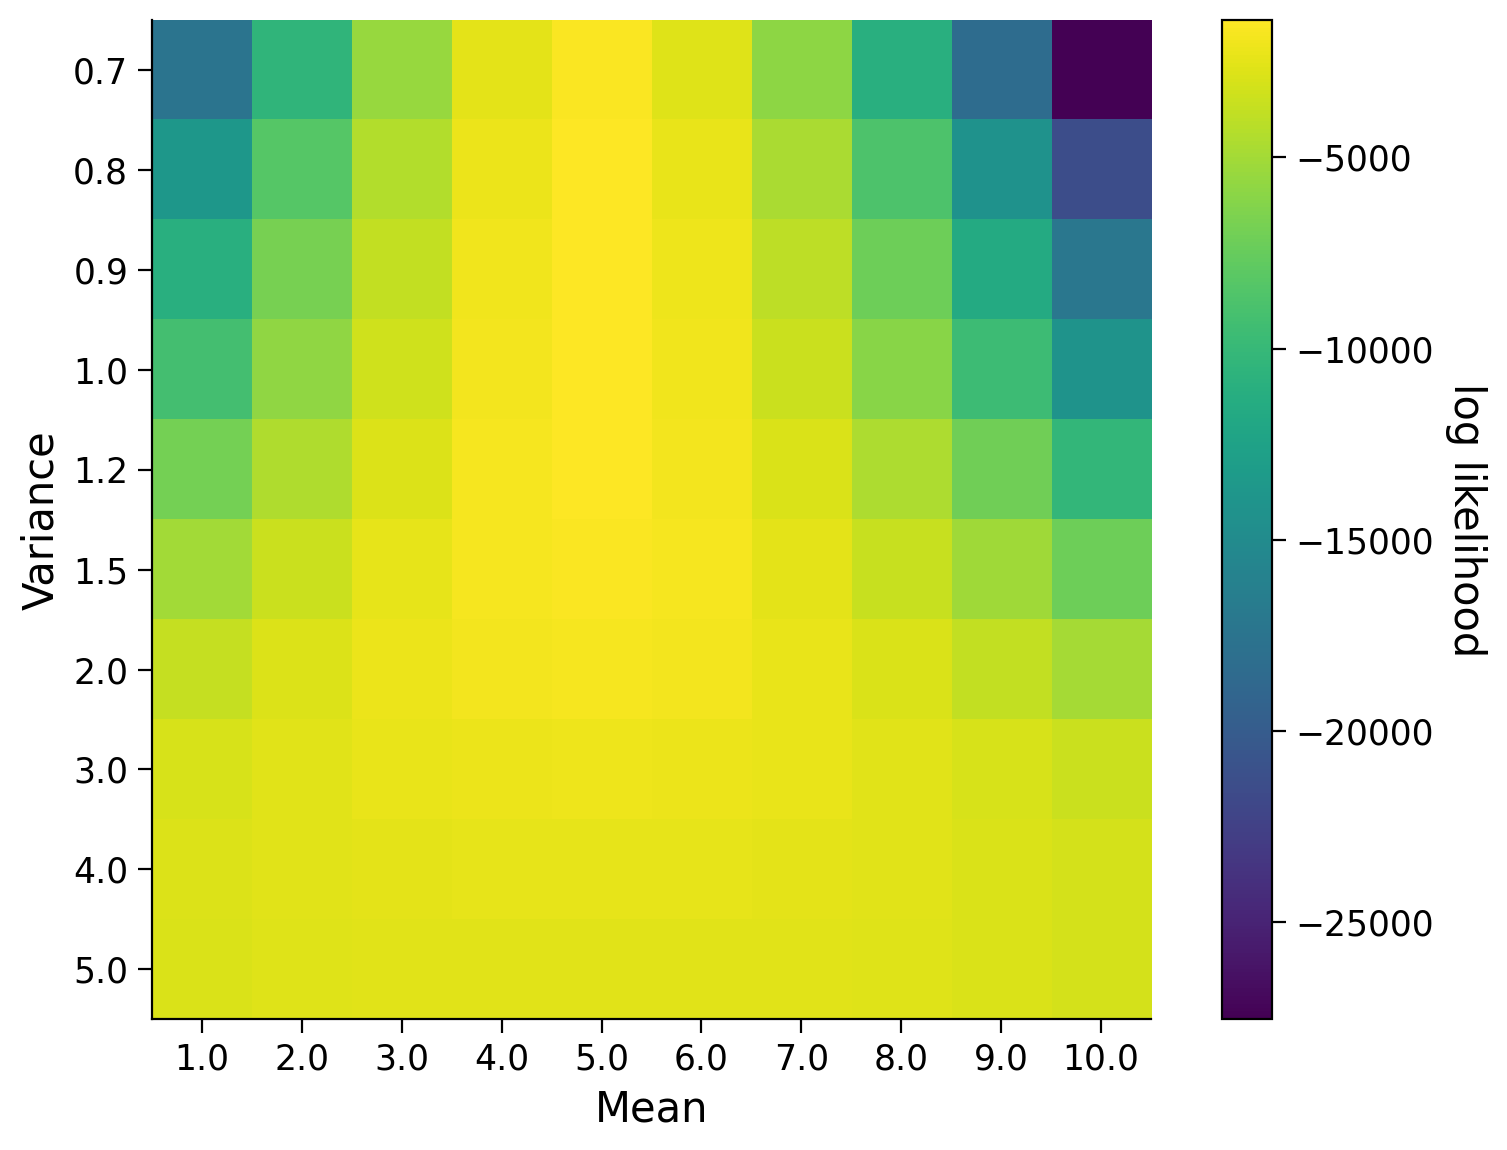

In [ ]:
# @title Execute to visualize likelihoods

# Set random seed
np.random.seed(0)

# Generate data
true_mean = 5
true_standard_dev = 1
n_samples = 1000
x = np.random.normal(true_mean, true_standard_dev, size = (n_samples,))


# Compute likelihood for different mean/variance values
mean_vals = np.linspace(1, 10, 10) # potential mean values to ry
standard_dev_vals = np.array([0.7, 0.8, 0.9, 1, 1.2, 1.5, 2, 3, 4, 5]) # potential variance values to try

# Initialise likelihood collection array
likelihood = np.zeros((mean_vals.shape[0], standard_dev_vals.shape[0]))

# Compute the likelihood for observing the gvien data x assuming
# each combination of mean and variance values
for idxMean in range(mean_vals.shape[0]):
  for idxVar in range(standard_dev_vals .shape[0]):
    likelihood[idxVar,idxMean]= sum(np.log(norm.pdf(x, mean_vals[idxMean],
                                              standard_dev_vals[idxVar])))

# Uncomment once you've generated the samples and compute likelihoods
xspace = np.linspace(0, 10, 100)
plot_likelihoods(likelihood, mean_vals, standard_dev_vals)

### 2.2: Searching for best parameters

We want to do inference on this data set, i.e. we want to infer the parameters that most likely gave rise to the data given our model. Intuitively that means that we want as good as possible a fit between the observed data and the probability distribution function with the best inferred parameters. We can search for the best parameters manually by trying out a bunch of possible values of the parameters, computing the likelihoods, and picking the parameters that resulted in the highest likelihood.

#### Interactive Demo 2.2: Maximum likelihood inference

Try to see how well you can fit the probability distribution to the data by using the demo sliders to control the mean and standard deviation parameters of the distribution. We will visualize the histogram of data points (in blue) and the Gaussian density curve with that mean and standard deviation (in red). Below, we print the log-likelihood.

- What (approximate) values of mu and sigma result in the best fit?
- How does the value below the plot (the log-likelihood) change with the quality of fit?

In [ ]:
# @title Make sure you execute this cell to enable the widget and fit by hand!
# Generate data
true_mean = 5
true_standard_dev = 1
n_samples = 1000
vals = np.random.normal(true_mean, true_standard_dev, size = (n_samples,))

def plotFnc(mu,sigma):
  loglikelihood= sum(np.log(norm.pdf(vals,mu,sigma)))
  #calculate histogram

  #prepare to plot
  fig, ax = plt.subplots()
  ax.set_xlabel('x')
  ax.set_ylabel('probability')

  #plot histogram
  count, bins, ignored = plt.hist(vals,density=True)
  x = np.linspace(0,10,100)

  #plot pdf
  plt.plot(x, norm.pdf(x,mu,sigma),'r-')
  plt.show()
  print("The log-likelihood for the selected parameters is: " + str(loglikelihood))

#interact(plotFnc, mu=5.0, sigma=2.1);
#interact(plotFnc, mu=widgets.IntSlider(min=0.0, max=10.0, step=1, value=4.0),sigma=widgets.IntSlider(min=0.1, max=10.0, step=1, value=4.0));
interact(plotFnc, mu=(0.0, 15.0, 0.1),sigma=(0.1, 5.0, 0.1));

interactive(children=(FloatSlider(value=7.5, description='mu', max=15.0), FloatSlider(value=2.5000000000000004…

### 2.3: Analytical solution

Sometimes, things work out well and we can come up with formulas for the maximum likelihood estimates of parameters. We won't get into this further but basically we could set the derivative of the likelihood to 0 (to find a maximum) and solve for the parameters. This won't always work but for the Gaussian distribution, it does.

Specifically , the special thing about the Gaussian is that mean and standard deviation of the random sample can effectively approximate the two parameters of a Gaussian, $\mu, \sigma$.


Hence using the  mean, $\bar{x}=\frac{1}{n}\sum_i x_i$, and variance, $\bar{\sigma}^2=\frac{1}{n} \sum_i (x_i-\bar{x})^2 $ of the sample should give us the best/maximum likelihood.

Complete the missing parts in the following piece of code to observe what are the estimate you find with the analytical method.

In [ ]:
# Set random seed
np.random.seed(0)

# Generate data
true_mean = 5
true_standard_dev = 1
n_samples = 1000
x = np.random.normal(true_mean, true_standard_dev, size = (n_samples,))

###################################################################
  ## TODO for student
###################################################################
# Compute and print sample means and standard deviations
sample_mean = np.sum(x)/n_samples
sample_std = np.sqrt(np.sum((x - sample_mean)**2)/n_samples)

print("This is the sample mean as estimated by analytical method: " + str(sample_mean))
print("This is the sample standard deviation as estimated by analytical method: " + str(sample_std))

This is the sample mean as estimated by analytical method: 4.9547432925098045
This is the sample standard deviation as estimated by analytical method: 0.9870331586690259


### 2.4: Numerical optimization to find parameters
Sometimes, it is not possible to find the optimal parameters analitycally and numerical methods must be used.


Let's again assume that we have a data set, $\mathbf{x}$, assumed to be generated by a normal distribution.
We want to maximise the likelihood of the parameters $\mu$ and $\sigma^2$. We can do so using a couple of tricks:

*   Using a log transform will not change the maximum of the function, but will allow us to work with very small numbers that could lead to problems with machine precision.
*   Maximising a function is the same as minimising the negative of a function, allowing us to use the minimize optimisation provided by scipy.

The optimisation could be done using `sp.optimize.minimize`, which does a version of gradient descent (there are hundreds of ways to do numerical optimisation, we will not cover these here!).

## Section 3: Bayesian Inference

In this section, you will apply the Bayes theorem, seen last week during the course, to a simple exemple with binary variables.

### 3.1 Putting things into practice

The world is full of latent variables that you cannot observe directly. Then you need to estimate these variables from the prior knowledge you have about it and some noisy measurements.

Bayesian inference is a method based on the Bayes theorem used to  combine prior knowledge and noisy measurements to infer an unknown state. The estimate obtained with the Bayes theorem is associated to some uncertainty (how confident we are that our estimate is true), and helps making a decision.

We will first handle binary states. It means that X can be either A or B. Next week, we will extend this theorem to continuous states, i.e. X can take any value between $-\infty \to \infty$.

Today, you're going to the lake, hoping to catch some fishes. At the dock, you have to decide if you are going to fish on the left side or on the right side. To make this decision, you would want to know which side the school of fish is on to maximise your chances to catch a fish. As you cannot see directly where they are (the fishes's state is the latent variable that you're trying to estimate), you will have to base your decision on your previous knowledge (for example, you know that most of the time, fishes are on the left) and on a measurement (a fisherperson is on the right side of the deck and has caught a fish).  
<Figure>
  <img alt='Gone fishing' align='centered' width=413 height=300 src=https://raw.githubusercontent.com/svandergoote/LGBIO2060-2021/master/Solutions/Gone%20fishing.PNG>

</Figure>



### 3.2: Theoretical reminder

The bayes theorem is the fundamental element of bayesian inference. It states that:  
\begin{equation}
 P(s | m) = \frac{P(m | s) P(s)}{P(m)}  \tag{1} \end{equation}

 where $s$ is the state and $m$ the measurement.

$p(s|m)$ is called the **posterior** (updated knowledge). It represents your belief after gaining information with the measurement. For example it is the probability that the school of fish is on the right given that a fisherperson caught a fish on the left side of the dock.

$p(m|s)$ is called the **likelihood**. It described of much information you gain from your measurement. For example, when fishing on the left it is the probability to catch a fish, given that the school is on the left.

$p(s)$ is the **prior knowledge**. It describes what you know about the hidden state, before taking a measurement. For example, you know that there is 70% of chance that the fishes are on the left.

$p(m)$ describes all possible measurements. It is a **normalization term**, also called the marginal likelihood or the evidence.

### 3.3 Likelihood

Let's think a bit about the likelihood. Suppose that you observe a fisherperson **fishing at the left side of the dock**. Either he caught a fish or he didn't. Let's say that you have 50% chance of catching a fish if you are on the correct side of the dock, but only 10% if your are at the wrong side of the dock.

1) Please figure out each of the following:
- probability of catching a fish given that the school of fish is on the left side, $P(m = \textrm{catch fish} | s = \textrm{left} )$
- probability of not catching a fish given that the school of fish is on the left side, $P(m = \textrm{no fish} | s = \textrm{left})$
- probability of catching a fish given that the school of fish is on the right side, $P(m = \textrm{catch  fish} | s = \textrm{right})$
- probability of not catching a fish given that the school of fish is on the right side, $P(m = \textrm{no fish} | s = \textrm{right})$

Sum up these answers in a numpy array as described in the next cell.

2) If the fisherperson catches a fish, which side would you guess the school is on?

3) If the fisherperson does not catch a fish, which side would you guess the school is on?



In [ ]:
###likelihood (ndarray): i x j array with likelihood probabilities where i is number of state options, j is number of measurement options

likelihood = np.array([[0.5, 0.5],
                       [0.1, 0.9]]) #first row is s = left, second row is s = right; first column is fish, second is no fish

### 3.4 Prior

In the previous exercise, you tried to guess where the school of fish was based on the measurement you took (watching someone fish). You did this by choosing the state that maximized the probability of the measurement. In other words, you estimated the state by maximizing the likelihood (recall the MLE you've encounter in the first tutorial).

But, what if you had been going to this dock for years and you knew that the fish were almost always on the right side? This should probably affect how you make your estimate -- you would rely less on the single new measurement and more on your prior knowledge. This is the fundamental idea behind Bayesian inference.

By running the next cell, we decide that $P(s = \textrm{left} )$ and $P(s = \textrm{right} )$ are respectively 0.3 and 0.7.


In [ ]:
#Run this cell
# p(s = left) = 0.3; p(s = right) = 0.7

prior = np.array([0.3, 0.7]).reshape((2, 1)) # first row is s = left, second row is s = right

### 3.5 Normalization (marginal likelihood)

When we normalize to find the posterior, we need to determine the marginal likelihood - or evidence - for the measurement we observed. As we do not have direct access to the normalization term $p(m)$, we need to compute it through the marginalization process. As stated in Equation 2-4, you can either use joint probabilities or conditional probabilities

$$p(m) = \sum_s p(m, s) \tag{2} $$


$$ p(m,s) = p(m|s)p(s) \tag{3} $$

\\

$$p(m) = \sum_s p(m | s) p(s) \tag{4} $$


Please complete the following math problem to further practice thinking through probabilities:

1. Calculate the marginal likelihood of the fish being caught, $P(m = \textrm{catch fish})$, considering the likelihoods and prior defined sooner (you are still observing a person fishing on the **left** side of the dock).


Normalizing by this $p(m)$ means that our posterior is a complete probability distribution that sums or integrates to 1 appropriately.
For many complicated cases, like those we might be using to model behavioral or brain inferences, the normalization term can be intractable or extremely complex to calculate. We can be careful to choose probability distributions were we can analytically calculate the posterior probability or numerical approximation is reliable. Better yet, we sometimes don't need to bother with this normalization! The normalization term, $p(m)$, is the probability of the measurement. This does not depend on state so is essentially a constant we can often ignore. We can compare the unnormalized posterior distribution values for different states because how they relate to each other is unchanged when divided by the same constant.

### 3.6 Posterior

You are now ready to put everything together !
Our prior is $p(s = \textrm{left}) = 0.3$ and $p(s = \textrm{right}) = 0.7$. We also learned that the chance of catching a fish given they fish on the same side as the school was 50%. Otherwise, it was 10%. We observe a person fishing on the left side.

First, calculate on paper the posterior probability that... (don't forget to normalize)

1. The school is on the left if the fisherperson catches a fish: $p(s = \textrm{left} | m = \textrm{fish})$
2. The school is on the right if the fisherperson does not catch a fish: $p(s = \textrm{right} | m = \textrm{no fish})$

Let's implement our above math to be able to compute posteriors for different priors and likelihoods. You are asked to fill a function taking the prior and likelihoods as argument and return the posteriors.  We want our full posterior to take the same 2 by 2 form. Make sure the outputs match your math answers!

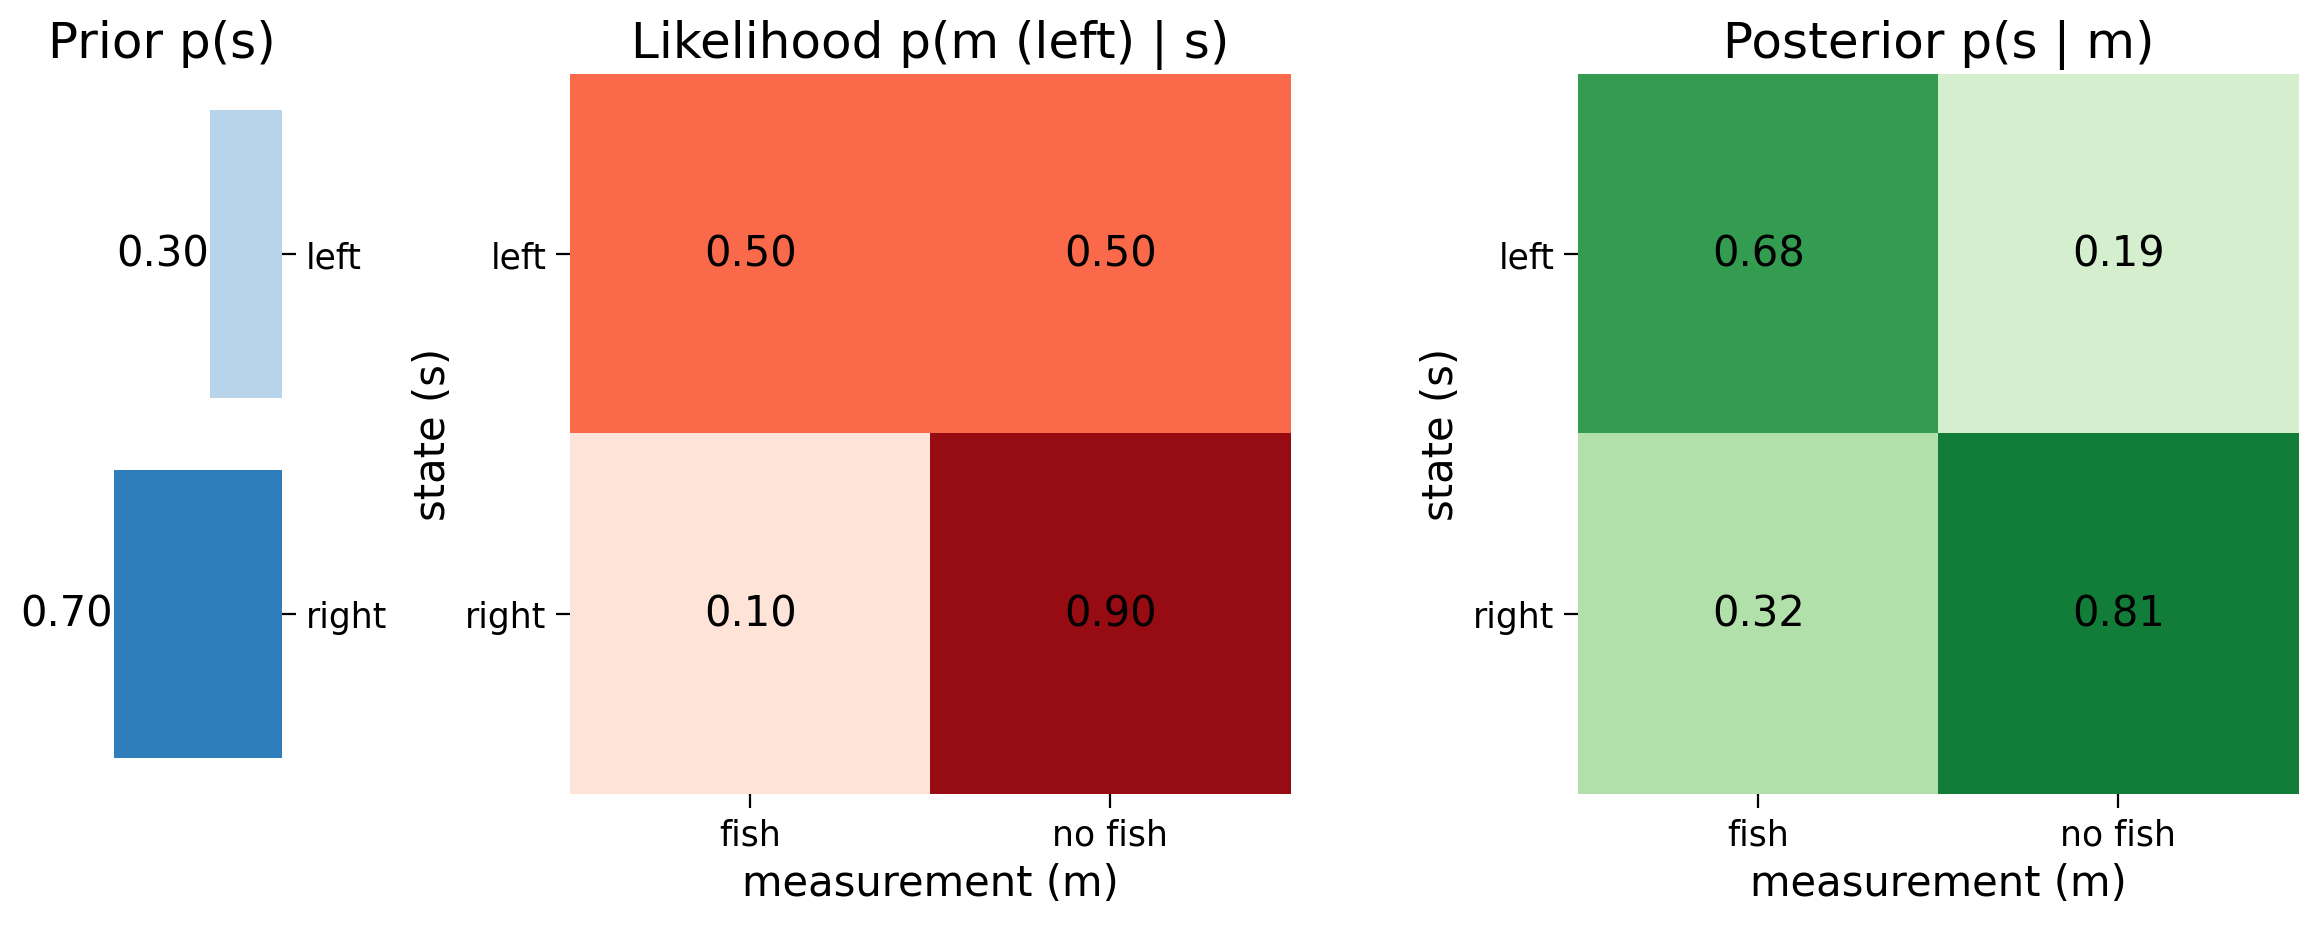

In [ ]:
def compute_posterior(likelihood, prior):
  """ Use Bayes' Rule to compute posterior from likelihood and prior

  Args:
    likelihood (ndarray): i x j array with likelihood probabilities where i is
                    number of state options, j is number of measurement options
    prior (ndarray): i x 1 array with prior probability of each state

  Returns:
    ndarray: i x j array with posterior probabilities where i is
            number of state options, j is number of measurement options

  """

  ############################
  ###### YOUR CODE HERE ######
  ############################
  posterior = likelihood * prior
  p_m = np.sum(posterior, axis=0) #We marginalize by taking the sum over S
  posterior /= p_m
  return posterior

# prior and likelihood defined above

# Compute posterior
posterior = compute_posterior(likelihood, prior)

# Visualize
plot_prior_likelihood_posterior(prior, likelihood, posterior)


*Example output:*

<img alt='Solution hint' align='left' width=1665.0 height=674.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D1_BayesianDecisions/static/W3D1_Tutorial1_Solution_1a2cc907_0.png>



#### Interactive Demo: What affects the posterior?

Now that we can understand the implementation of *Bayes rule*, let's vary the parameters of the prior and likelihood to see how changing the prior and likelihood affect the posterior.

In the demo below, you can change the prior by playing with the slider for $p( s = left)$. You can also change the likelihood by changing the probability of catching a fish given that the school is on the left and the probability of catching a fish given that the school is on the right. The fisherperson you are observing is fishing on the left.


1.   Keeping the likelihood constant, when does the prior have the strongest influence over the posterior? Meaning, when does the posterior look most like the prior no matter whether a fish was caught or not?
2.   What happens if the likelihoods for catching a fish are similar when you fish on the correct or incorrect side?
3.  Set the prior probability of the state = left to 0.6 and play with the likelihood. When does the likelihood exert the most influence over the posterior?

In [ ]:
# @markdown Execute this cell to enable the widget
style = {'description_width': 'initial'}

ps_widget = widgets.FloatSlider(0.3, description='p(s = left)',
                                min=0.01, max=0.99, step=0.01)
p_a_s1_widget = widgets.FloatSlider(0.5, description='p(fish on left | state = left)',
                                    min=0.01, max=0.99, step=0.01, style = style, layout=Layout(width='370px'))
p_a_s0_widget = widgets.FloatSlider(0.1, description='p(fish on left | state = right)',
                                    min=0.01, max=0.99, step=0.01, style = style, layout=Layout(width='370px'))
# observed_widget = widgets.Checkbox(value=False, description='Observed fish (m)',
#                                  disabled=False, indent=False,
#                                  layout=Layout(display="flex", justify_content="center"))

observed_widget = ToggleButtons(options=['Fish', 'No Fish'],
    description='Observation (m) on the left:', disabled=False, button_style='',
    layout=Layout(width='auto', display="flex"),
    style={'description_width': 'initial'}
)

widget_ui = VBox([ps_widget,
                  HBox([p_a_s1_widget, p_a_s0_widget]),
                  observed_widget])
widget_out = interactive_output(plot_prior_likelihood,
                                {'ps': ps_widget,
                                'p_a_s1': p_a_s1_widget,
                                'p_a_s0': p_a_s0_widget,
                                'measurement': observed_widget})
display(widget_ui, widget_out)

# @widgets.interact(
#     ps=ps_widget,
#     p_a_s1=p_a_s1_widget,
#     p_a_s0=p_a_s0_widget,
#     m_right=observed_widget
# )
# def make_prior_likelihood_plot(ps,p_a_s1,p_a_s0,m_right):
#     fig = plot_prior_likelihood(ps,p_a_s1,p_a_s0,m_right)
#     plt.show(fig)
#     plt.close(fig)
#     return None

Output()

We now can use this new, complete probability distribution for any future inference or decisions we like! In fact, as we will see in the second part of the tutorial, we can use it as a new prior! Finally, we often call this probability distribution our beliefs over the hidden states, to emphasize that it is our subjective knowlege about the hidden state.

### 3.7 Utility and decision
Now that you have some belief about the location of the fishes, you need to decide where to fish. It may seem obvious - you could just fish on the side where the probability of the fish being is higher. Unfortunately, decisions and actions are always a little more complicated. Deciding where to fish may be influenced by more than just the probability of the school of fish being there. In our example, it is more difficult to fish on the right side because there is a motor boat at this side of the lake. Additionally, fishing on the wrong side, where there aren’t many fish, is likely to lead to you spending your afternoon not catching fish and therefore getting a sunburn. The consequences of the action you take is based on the true (but hidden) state of the world **and** the action you choose !

We quantify gains and losses numerically using a **utility** function $U(s,a)$, which describes the consequences of your actions: how much value you gain (or if negative, lose) given the state of the world ($s$) and the action you take ($a$). In our example, our utility can be summarized as:

|  U(s,a)   | a = left   | a = right  |
| ----------------- |------------|------------|
| s = Left          | +2         | -3         |
| s = right         | -2         | +1         |


If you want to know what to expect from taking the action of fishing on one side or the other, you need to calculate the expected utility by weighing the utilities with the probability of that state occuring. This allows us to choose actions by taking probabilities of events into account: we don't care if the outcome of an action-state pair is a loss if the probability of that state is very low. We can formalize this as:

$$ \text{Expected utility of action a} = \sum_{s}U(s,a)P(s) $$

Implement a function `expected_utility(utility, posterior)` to compute the expected utility associated with an action, given the probability of a state. Then, for each of these scenarios, determine which action would have been correct.

1.  You just arrived at the dock for the first time and have no sense of where the fish might be. Which side would you choose to fish on given our utility values?
2.  You think that the probability of the school being on the left side is very low (0.1) and correspondingly high on the right side (0.9). Which side would you choose to fish on given our utility values?
3. What probability distribution of the states would give you equal expected utility ?

Note that we can use our posterior probability as the probability of the state $P(s)$.

As you have seen in the previous interactive demo, once you determined the measurement $m$, your posterior probabilities is no longer a 2x2 array. It becomes a 2x1 vector that can be called $P(s)$ as it does no longer depends on a variable $m$. Keep in mind that $P(s)$ is the probability of the state $s$ and can be therefore a prior probability (before taking any measurement) or a posterior probability (probability that integrate the knowledge gained with 1 or several measurement(s)).

In [ ]:
def expected_utility(utility, state_proba):
  """ Compute expected utility from utility and probability distribution of the state

  Args:
    utility (ndarray): i x j array with utility where i is
                    number of state options, j is number of action options
    state_proba (ndarray): i x 1 array with probability of each state

  Returns:
    expected_utility (ndarray): 1 x i array with the expected utility where i is
            number of action options

  """
  ############################
  ###### YOUR CODE HERE ######
  ############################
  expected_utility = utility * state_proba
  expected_utility = np.sum(expected_utility, axis=0)
  return expected_utility

utility = np.array([[2, -3],
                    [-2, 1]])
state_proba = np.array([[3/8],
                        [5/8]])

print(expected_utility(utility, state_proba))

[-0.5 -0.5]


1) If you have no idea then P(s=left) = P(s=right) = 0.5. You compute the following expected utility : 0 and -1. Based on this result you should decide to fish on the left side.

2)You obtain -1.6 and 0.6 then you decide to fish on the right.

3)You obtain -0.5 and -0.5 for P(s=left)=3/8 and P(s=right)=5/8

#### Interactive Demo: What is more important, the probabilities or the utilities?

Play a bit with the following widget to gain some intuitions on how each element that goes into a Bayesian decision comes together. Remember, the common assumption in neuroscience, psychology, economics, ecology, etc. is that we (humans and animals) are tying to maximize our expected utility.

In [ ]:
# @markdown Execute this cell to enable the widget
# style = {'description_width': 'initial'}

ps_widget = widgets.FloatSlider(0.3, description='p(s = left)',
                                min=0.01, max=0.99, step=0.01, layout=Layout(width='300px'))
p_a_s1_widget = widgets.FloatSlider(0.5, description='p(fish on left | state = left)',
                                    min=0.01, max=0.99, step=0.01, style=style, layout=Layout(width='370px'))
p_a_s0_widget = widgets.FloatSlider(0.1, description='p(fish on left | state = right)',
                                    min=0.01, max=0.99, step=0.01, style=style, layout=Layout(width='370px'))

observed_widget = ToggleButtons(options=['Fish', 'No Fish'],
    description='Observation (m) on the left:', disabled=False, button_style='',
    layout=Layout(width='auto', display="flex"),
    style={'description_width': 'initial'}
)

widget_ui = VBox([ps_widget,
                  HBox([p_a_s1_widget, p_a_s0_widget]),
                  observed_widget])

widget_out = interactive_output(plot_prior_likelihood_utility,
                                {'ps': ps_widget,
                                'p_a_s1': p_a_s1_widget,
                                'p_a_s0': p_a_s0_widget,
                                'measurement': observed_widget})
display(widget_ui, widget_out)

# @widgets.interact(
#     ps=ps_widget,
#     p_a_s1=p_a_s1_widget,
#     p_a_s0=p_a_s0_widget,
#     m_right=observed_widget
# )
# def make_prior_likelihood_utility_plot(ps, p_a_s1, p_a_s0,m_right):
#     fig = plot_prior_likelihood_utility(ps, p_a_s1, p_a_s0,m_right)
#     plt.show(fig)
#     plt.close(fig)
#     return None

Output()